In [1]:
# Import necessary libraries
import cobra
import glob
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import random
import seaborn as sns
import numpy as np

from cobra.medium import minimal_medium
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

input_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/network_files/'
model_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/'
output_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/'
sample_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/phyloseq_source/'
figure_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Figures/'

In [ ]:
# Load all the models
os.chdir(model_path)

# Create an empty DataFrame to store the results
model_info = pd.DataFrame(columns=["Model", "Predicted growth rate", "Number of Genes", "Number of Metabolites", "Number of Reactions"])

# Loop through each SBML file
for models in os.listdir(model_path):
    if models.endswith(".xml"): 
        model = cobra.io.read_sbml_model(models) 
        solution = model.optimize()
        model_info.loc[len(model_info)] = { 
            "Model": models, 
            "Predicted growth rate": solution.objective_value,
            "Number of Genes": len(model.genes),
            "Number of Metabolites": len(model.metabolites),
            "Number of Reactions": len(model.reactions)
        }

model_info.set_index('Model', inplace=True)

# Save the results
model_info.to_csv(output_path + 'model_info.csv', sep = ",", index = True)

model_info

In [3]:
# Generating smetana scores for the communities
environments = ["Hospital", "MetaSUB", "Office"]

# Loading nodes/ interactions informations
nodes_info, edges_info = {}, {}

for env in environments:
    net_edges = pd.read_csv(input_path + env + '_edges.tsv', sep = ",")
    nodes = list(set((list(net_edges['v1']) + list(net_edges['v2']))))
    nodes_info[env] = nodes
    edges_info[env] = net_edges

# Loading abundance information
sample_info = {}

for env in environments:
    sample_info[env] = pd.read_csv(sample_path + env + '_filtered_data.csv', sep = ",")
    sample_info[env].set_index('Species', inplace = True)

sample_info['Hospital'].head()
#edges_info['Hospital'].head()

,MEE001,MEE002,MEE003,MEE004,MEE005,MEE006,MEE007,MEE008,MEE009,MEE010,...,WEE376,WEE377,WEE378,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.00000,0.00317,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00000,0.00000,0.17724,0.00000,0.0,0.00578,0.00000,0.00129,0.00777,0.00518
Achromobacter xylosoxidans,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00215,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
Acinetobacter baumannii,0.00258,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.01955,0.00427,0.01885,0.00785,0.0,0.02886,0.00532,0.00551,0.00291,0.01378
Acinetobacter johnsonii,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00255,0.0,0.00000,0.01293,0.00204,0.00000,0.00000
Acinetobacter junii,0.00281,0.01040,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00193,0.00000,0.00468,0.00409,0.0,0.00300,0.00311,0.00556,0.00000,0.00400


In [22]:
def get_non_zero_distribution(df):
    non_zero_counts = (df != 0).sum()
    return pd.DataFrame({
        'Column': non_zero_counts.index,
        'NonZeroCount': non_zero_counts.values
    })

# Prepare the data for FacetGrid
plot_data = []
for name, df in sample_info.items():
    df_non_zero_dist = get_non_zero_distribution(df)
    df_non_zero_dist['DataFrame'] = name
    plot_data.append(df_non_zero_dist)

plot_data = pd.concat(plot_data)

# Plot the data
g = sns.FacetGrid(plot_data, col="DataFrame", col_wrap=2, sharex=False, sharey=True, height=4)
g.map(sns.barplot, 'Column', 'NonZeroCount', order=plot_data['Column'].unique())
#
## Adjust the plots
#for ax in g.axes.flatten():
#    for label in ax.get_xticklabels():
#        label.set_rotation(45)
#    ax.set_ylabel('Non-Zero Count')
#
#g.set_titles(col_template="{col_name}")
#plt.tight_layout()
#plt.show()

plot_data

,Column,NonZeroCount,DataFrame
0,MEE001,28,Hospital
1,MEE002,36,Hospital
2,MEE003,3,Hospital
3,MEE004,1,Hospital
4,MEE005,15,Hospital
...,...,...,...
25,WEE330,16,Office
26,WEE349,11,Office
27,WEE368,11,Office
28,WEE387,14,Office


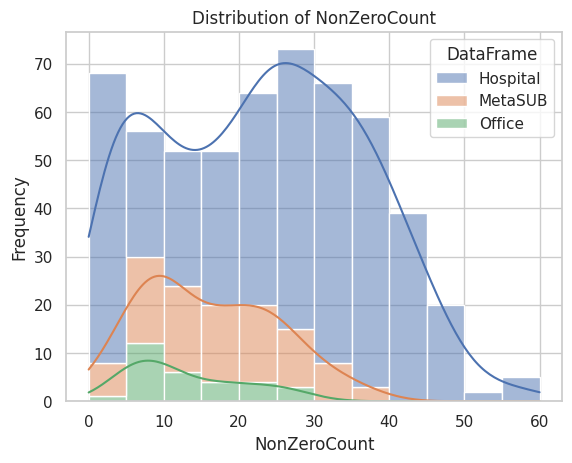

In [23]:
# Plotting
sns.histplot(data=plot_data, x='NonZeroCount', hue='DataFrame', multiple='stack', kde=True)

# Customize the plot
plt.title('Distribution of NonZeroCount')
plt.xlabel('NonZeroCount')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [4]:
# Saving network information from the edge file to the networkx graph
network_info = {}

for env in environments:
    G = nx.Graph()

    # Add edges
    for _, row in edges_info[env].iterrows():
        G.add_edge(row['v1'], row['v2'], weight = row['Weight'])
    
    network_info[env] = G
    
# Network details
network_data = pd.DataFrame(columns=["Network", "Number of Nodes", 
                                    "Number of Edges"])

for graph_name, graph in network_info.items():

    # Extract network information
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    # Create a DataFrame to store the results
    network_data.loc[len(network_data)] = [graph_name, num_nodes, num_edges]

network_data.set_index('Network', inplace=True)
network_data

,Number of Nodes,Number of Edges
Network,,
Hospital,83,506
MetaSUB,43,97
Office,14,30


In [5]:
# Overall available communities for random selection
all_orgs = set()
for df in sample_info.values():
    all_orgs.update(df.index)

all_orgs_list = list(all_orgs)

len(all_orgs_list)

114

In [6]:
# Set a seed for reproducibility
random.seed(42)

# Generate environment-specific communities
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=sample_info):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)  
        subgraph = graph.subgraph(nodes)  

        if nx.is_connected(subgraph):  
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]
            samples = (sample_subset != 0).all()

            if samples.sum() > 0:
                # Generating actual communities
                community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}" 
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                ## generating random communities with the same number of nodes
                #rand_samples = random.choice(list(samples[samples].index))
                #rand_sample_subset = sample_info[env][rand_samples]
                #rand_organism_ids = random.sample(list(rand_sample_subset[rand_sample_subset != 0].index), k = num_nodes)

                #rand_community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}_random" 
                #for rand_org_id in rand_organism_ids:
                #    community_df["community id"].append(rand_community_id)
                #    community_df["organism id"].append(rand_org_id)
                
                communities_generated += 1
                
                # Plot the subgraph
                #figure = plt.figure(figsize=(5, 5))
                #nx.draw(subgraph, with_labels=True)

    return pd.DataFrame(community_df)

# Generate random communities
def generate_rand_community(num_nodes=5, num_subgraphs=10, all_orgs=all_orgs_list):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        nodes = random.sample(all_orgs, num_nodes)  

        # Generating random communities
        community_id = f"Random_{num_nodes}_{num_subgraphs}_{communities_generated+1}"
        for org_id in nodes:
            community_df["community id"].append(community_id)
            community_df["organism id"].append(org_id)

        communities_generated += 1

    return pd.DataFrame(community_df)

In [7]:
# Set a seed for reproducibility
random.seed(42)

# Simulating communities
com_size = [2, 5, 8]
num_com = [10]

# Overall community information
community_info = pd.DataFrame({"community id": [], "organism id": []})

# Adding random community information
all_com_env = np.append(environments, ['Random'])

# Generate communities
for env in all_com_env:
    for size in com_size:
        for num in num_com:
            if env != 'Random':
                community_df = generate_community(network_info[env], env=env, num_nodes=size, num_subgraphs=num, sample_info=sample_info)
                community_info = pd.concat([community_info, community_df], ignore_index=True)
                print(f"Number of communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")
                #community_df.to_csv(output_path + env + f'_communities_{size}_{num}.csv', sep = ",", index = False)

            else:
                community_df = generate_rand_community(num_nodes=size, num_subgraphs=num, all_orgs=all_orgs_list)
                community_info = pd.concat([community_info, community_df], ignore_index=True)
                print(f"Number of random communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")

community_info['organism id'] = community_info['organism id'].str.replace(' ', '_')

# Changing the name according to the models
community_info['organism id'] = community_info['organism id'].str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Dermacoccus_sp._Ellin185', 'Dermacoccus_sp.')

# Save the community
community_info.to_csv(output_path + 'community_info.csv', sep = "\t", index = False, header=False)

community_info

Number of communities generated for Hospital with 2 nodes and 10 communities: 20
Number of communities generated for Hospital with 5 nodes and 10 communities: 50
Number of communities generated for Hospital with 8 nodes and 10 communities: 80
Number of communities generated for MetaSUB with 2 nodes and 10 communities: 20
Number of communities generated for MetaSUB with 5 nodes and 10 communities: 50
Number of communities generated for MetaSUB with 8 nodes and 10 communities: 80
Number of communities generated for Office with 2 nodes and 10 communities: 20
Number of communities generated for Office with 5 nodes and 10 communities: 50
Number of communities generated for Office with 8 nodes and 10 communities: 80
Number of random communities generated for Random with 2 nodes and 10 communities: 20
Number of random communities generated for Random with 5 nodes and 10 communities: 50
Number of random communities generated for Random with 8 nodes and 10 communities: 80


,community id,organism id
0,Hospital_2_10_1,Klebsiella_pneumoniae
1,Hospital_2_10_1,Methylobacterium_radiotolerans
2,Hospital_2_10_2,Micrococcus_luteus
3,Hospital_2_10_2,Serratia_marcescens
4,Hospital_2_10_3,Corynebacterium_tuberculostearicum
...,...,...
595,Random_8_10_10,Serratia_marcescens
596,Random_8_10_10,Scardovia_wiggsiae
597,Random_8_10_10,Dietzia_cinnamea
598,Random_8_10_10,Microbacterium_laevaniformans


In [8]:
# Check model names
model_files = glob.glob(model_path + '*.xml')
model_files = [os.path.basename(file) for file in model_files]
model_files = [file.replace('.xml', '') for file in model_files]

model_files

mismatch = list(set(list(community_info['organism id'])) - set(model_files))
mismatch

[]

In [9]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Smetana_output/Com_2-5-8_10_v2.csv \\\n")
    f.write("    --solver cplex --flavor bigg --molweight")

In [10]:
# Run the bash script
!chmod +x {output_path + 'run_smetana.sh'}
!bash {output_path + 'run_smetana.sh'}

/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Staphylococcus_aureus
  warn('MRO: Failed to find a valid solution for: ' + org_id)
/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Corynebacterium_resistens
  warn('MRO: Failed to find a valid solution for: ' + org_id)


In [13]:
# Visualisation
smetana_results = pd.read_csv(output_path + 'Smetana_output/Com_2-5-8_10_v2.csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number']] = smetana_results['community'].str.split('_', expand = True)

smetana_results

,community,medium,size,mip,mro,Environment,Community Size,Iterations,Community Number
0,Hospital_2_10_1,complete,2,1,0.620690,Hospital,2,10,1
1,Hospital_2_10_10,complete,2,0,0.826087,Hospital,2,10,10
2,Hospital_2_10_2,complete,2,1,0.642857,Hospital,2,10,2
3,Hospital_2_10_3,complete,2,0,0.838710,Hospital,2,10,3
4,Hospital_2_10_4,complete,2,0,0.733333,Hospital,2,10,4
...,...,...,...,...,...,...,...,...,...
115,Random_8_10_5,complete,8,9,0.655936,Random,8,10,5
116,Random_8_10_6,complete,8,11,0.692641,Random,8,10,6
117,Random_8_10_7,complete,8,14,0.622601,Random,8,10,7
118,Random_8_10_8,complete,8,14,0.650913,Random,8,10,8


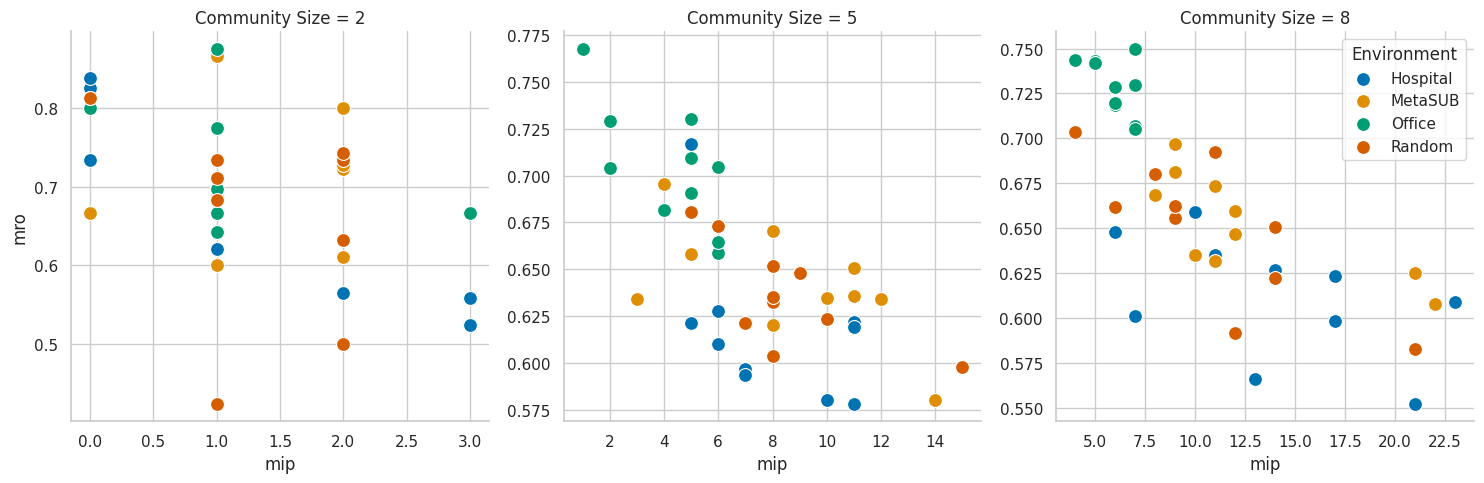

In [29]:
# Create the scatter plot with seaborn
sns.set(style="whitegrid")

# Create a FacetGrid for subplots by 'Community Size'
g = sns.FacetGrid(smetana_results, col="Community Size", hue="Environment", palette="colorblind", 
                        height=5, aspect=1, legend_out=True, sharex=False, sharey=False)

# Map the scatterplot to the grid
g.map(sns.scatterplot, 'mip', 'mro', s=100)

# Add legend
plt.legend(title="Environment")

plt.savefig(figure_path + 'smetana_scatterplot.svg', format='svg', dpi=500)
plt.show()

In [51]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana_minimal.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Smetana_output/Com_2-5-8_5_M9_v1.csv \\\n")
    f.write("    --solver cplex --flavor bigg --molweight \\\n")
    f.write("    -m M9 --mediadb /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/media_db.tsv")

In [52]:
# Run the bash script
!chmod +x {output_path + 'run_smetana_minimal.sh'}
!bash {output_path + 'run_smetana_minimal.sh.sh'}

bash: /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/run_smetana_minimal.sh.sh: No such file or directory


In [ ]:
# Generating minimal media for the communities

model_files = glob.glob(model_path + '*.xml')
minimal_media = {}

for env in environments:
    media = []
    organisms = nodes_info[env]
    organisms = sorted([org.replace(" ", "_") for org in organisms])
    models = [item for item in model_files if any(organism in item for organism in organisms)]
    for model in models:
        model_obj = cobra.io.read_sbml_model(model)
        media += list(minimal_medium(model_obj, 0.1, minimize_components=True).keys())

    media = sorted(list(set([element[3:] for element in media])))
    minimal_media[env] = media

minimal_media